In [288]:
import os

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="white", context="talk")
mpl.rcParams['figure.figsize'] = [12.0, 9.0]

%matplotlib inline

In [194]:
DIR = "Y:\HGAC_2County\AM_2018_nobuild290\HGAC_V10AM\_rpt"
FILE_NAME_LINK = "HGAC4-Link.csv"
FILE_NAME_FLOW = "OutFlow_HGAC4_full.csv"
FILE_NAME_DENSITY = "OutLinkDent_HGAC4_full.csv"
FILE_NAME_SPEED = "OutLinkSpeedAll_HGAC4_full.csv"
FILE_NAME_TT = "OutLinkTravelTime_HGAC4_full.csv"
FILE_NAME_VOL = "OutAccuVol_HGAC4_full.csv"

FILE_LINK = os.path.join(DIR, FILE_NAME_LINK)
FILE_FLOW = os.path.join(DIR, FILE_NAME_FLOW)
FILE_DENSITY = os.path.join(DIR, FILE_NAME_DENSITY)
FILE_SPEED = os.path.join(DIR, FILE_NAME_SPEED)
FILE_TT = os.path.join(DIR, FILE_NAME_TT)
FILE_VOL = os.path.join(DIR, FILE_NAME_VOL)

In [260]:
# To-do: Remove "#" and types in parentheses using RE?
link_useful_cols = [
    
    'A_NODE(f0)', 'B_NODE(f0)', '#STREET(c20)','#LTYPE(f0)', 
    'DISTANCE(f2)', '#LENGTH(f0)', '#LANES(f0)', '#SPEED(f0)', 
    '#SATFLOW(f0)', '#SERFLOW(f0)', '#VOLUME(f0)', '#TIME(f0)', '#DELAY(f2)'
    
]
df_link = pd.read_csv(FILE_LINK, index_col=False).loc[:, link_useful_cols]
df_link.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45874 entries, 0 to 45873
Data columns (total 13 columns):
A_NODE(f0)      45874 non-null int64
B_NODE(f0)      45874 non-null int64
#STREET(c20)    45874 non-null object
#LTYPE(f0)      45840 non-null float64
DISTANCE(f2)    45874 non-null float64
#LENGTH(f0)     45840 non-null float64
#LANES(f0)      45840 non-null float64
#SPEED(f0)      45840 non-null float64
#SATFLOW(f0)    45840 non-null float64
#SERFLOW(f0)    45840 non-null float64
#VOLUME(f0)     45840 non-null float64
#TIME(f0)       45840 non-null float64
#DELAY(f2)      45840 non-null float64
dtypes: float64(10), int64(2), object(1)
memory usage: 4.5+ MB


In [261]:
def clean_col_name(col):
    '''
    get only the alphanumeric letters and remove anything in the parentheses
    col: a string
    '''
    
    col = col[(col.find('#')+1):(col.find('('))]
    return col

In [262]:
df_link = df_link.rename(columns=clean_col_name).rename(columns=str.title).rename(columns={'A_Node':'Anode',
                                                                 'B_Node':'Bnode',
                                                                 'Time':'Avg_Travel_Time',
                                                                 'Volume': 'Total_Volume',
                                                                 'Delay': 'Avg_Delay',
                                                                 'Speed': 'Speed_limit'                          
                                                                })
df_link.columns

Index(['Anode', 'Bnode', 'Street', 'Ltype', 'Distance', 'Length', 'Lanes',
       'Speed_limit', 'Satflow', 'Serflow', 'Total_Volume', 'Avg_Travel_Time',
       'Avg_Delay'],
      dtype='object')

In [263]:
def pivot_df(df, measure):
    '''
    Pivot the raw performance measure dataframe to the following format
    Link, Anode, Bnode, Time, [measure]
    where [measure] is the name of the measure
    '''
    df = df.drop(df.columns.tolist()[-1], axis=1).drop(['Dist', 'Lanes'], axis=1)
    value_cols = [col for col in df.columns.tolist() if col not in ['Link','Anode','Bnode','Dist','Lanes']]
    df = pd.melt(df, id_vars=['Link', 'Anode', 'Bnode'], value_vars=value_cols, var_name='Interval', value_name=measure)
    return df

In [264]:
df_flow = pd.read_csv(FILE_FLOW, index_col=False).pipe(pivot_df, 'Flow').assign(Interval=lambda x: pd.to_numeric(x['Interval']))
df_density = pd.read_csv(FILE_DENSITY, index_col=False).pipe(pivot_df, 'Density').assign(Interval=lambda x: pd.to_numeric(x['Interval']))
df_speed = pd.read_csv(FILE_SPEED, index_col=False).pipe(pivot_df, 'Speed').assign(Interval=lambda x: pd.to_numeric(x['Interval']))
df_tt = pd.read_csv(FILE_TT, index_col=False).pipe(pivot_df, 'Travel_Time').assign(Interval=lambda x: pd.to_numeric(x['Interval']))
df_vol = pd.read_csv(FILE_VOL, index_col=False).pipe(pivot_df, 'Volume').assign(Interval=lambda x: pd.to_numeric(x['Interval']))

In [265]:
df_vol.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234306 entries, 0 to 234305
Data columns (total 5 columns):
Link        234306 non-null int64
Anode       234306 non-null int64
Bnode       234306 non-null int64
Interval    234306 non-null int64
Volume      234306 non-null float64
dtypes: float64(1), int64(4)
memory usage: 8.9 MB


In [266]:
df_vol_shifted = df_vol.copy()
df_vol_shifted.loc[:,'Interval'] = df_vol_shifted.loc[:,'Interval'] + 1
df_vol_join = pd.merge(df_vol, df_vol_shifted, how='left', left_on=['Link','Anode','Bnode','Interval'], 
                      right_on=['Link','Anode','Bnode','Interval'], suffixes=('_1','_2')).fillna(df_vol)
df_vol_join['Volume'] = df_vol_join['Volume_1'] - df_vol_join['Volume_2'] 
df_vol = df_vol_join.loc[:,['Link','Anode','Bnode','Interval','Volume']]

In [280]:
df_vol_join.head(20)

,Link,Anode,Bnode,Interval,Volume_1,Volume_2,Volume
0,9116,3417,9364,1,0.00,0.0,0.00
1,9117,3417,9424,1,0.00,0.0,0.00
2,9118,3418,9929,1,50.02,0.0,50.02
3,9119,3419,9931,1,50.50,0.0,50.50
4,9120,3420,10238,1,51.40,0.0,51.40
5,9121,3421,9837,1,75.53,0.0,75.53
6,9130,3430,10080,1,27.12,0.0,27.12
7,9131,3431,9937,1,58.93,0.0,58.93
8,9134,3432,7486,1,11.82,0.0,11.82
9,9135,3433,17118,1,39.38,0.0,39.38


In [281]:
df_vol_join.loc[df_vol_join.Link == 9118]

,Link,Anode,Bnode,Interval,Volume_1,Volume_2,Volume
2,9118,3418,9929,1,50.02,0.00,50.02
26036,9118,3418,9929,2,81.85,50.02,31.83
52070,9118,3418,9929,3,123.78,81.85,41.93
78104,9118,3418,9929,4,196.88,123.78,73.10
104138,9118,3418,9929,5,322.47,196.88,125.59
130172,9118,3418,9929,6,424.17,322.47,101.70
156206,9118,3418,9929,7,484.03,424.17,59.86
182240,9118,3418,9929,8,528.75,484.03,44.72
208274,9118,3418,9929,9,528.75,528.75,0.00


In [267]:
# join all measures into one dataframe
def join_dfs(dfs, index_cols):
    '''
    Join all measures into one dataframe based on the index columns 
    '''
    
    dfs = [df.set_index(index_cols) for df in dfs]
    return pd.concat(dfs, axis=1).reset_index()
    

In [268]:
df_metric = join_dfs([df_flow, df_density, df_speed, df_tt, df_vol], ['Link','Anode','Bnode','Interval'])
df_metric = pd.merge(df_metric, df_link, how='left', left_on=['Anode', 'Bnode'], right_on=['Anode', 'Bnode'])
df_metric.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 234306 entries, 0 to 234305
Data columns (total 20 columns):
Link               234306 non-null int64
Anode              234306 non-null int64
Bnode              234306 non-null int64
Interval           234306 non-null int64
Flow               234306 non-null float64
Density            234306 non-null float64
Speed              234306 non-null float64
Travel_Time        234306 non-null float64
Volume             234306 non-null float64
Street             234306 non-null object
Ltype              234306 non-null float64
Distance           234306 non-null float64
Length             234306 non-null float64
Lanes              234306 non-null float64
Speed_limit        234306 non-null float64
Satflow            234306 non-null float64
Serflow            234306 non-null float64
Total_Volume       234306 non-null float64
Avg_Travel_Time    234306 non-null float64
Avg_Delay          234306 non-null float64
dtypes: float64(15), int64(4), object(

### Compute additional metrics
1. FF_Time: Free-flow travel time = Distance / Speed_limit
2. TTR: travel time ratio
3. VC:  Flow / (Lanes * Service_Flow)

In [270]:
df_metric.loc[:,'FF_Time'] = np.where(df_metric.loc[:,'Speed_limit']>0, 
                                           df_metric.loc[:,'Distance'] / df_metric.loc[:,'Speed_limit'] * 60,
                                                df_metric.loc[:,'Distance'] / 25 * 60                                  
                                           ) 

In [271]:
df_metric['TTR'] = df_metric['Travel_Time'] / df_metric['FF_Time']

In [272]:
df_metric['VC'] = df_metric['Flow'] / (df_metric['Lanes'] * df_metric['Serflow'])
df_metric['VC2'] = df_metric['Flow'] / (df_metric['Lanes'] * df_metric['Satflow'])

In [273]:
df_metric['Flow2'] = df_metric['Volume'] / df_metric['Lanes']

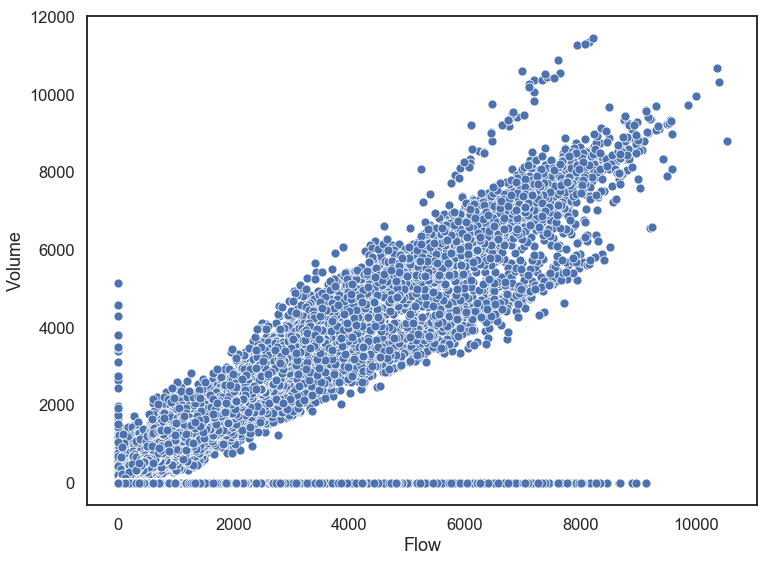

In [286]:
fig, ax = plt.subplots(figsize=(12,9))
sns.scatterplot(df_metric.Flow, df_metric.Volume)

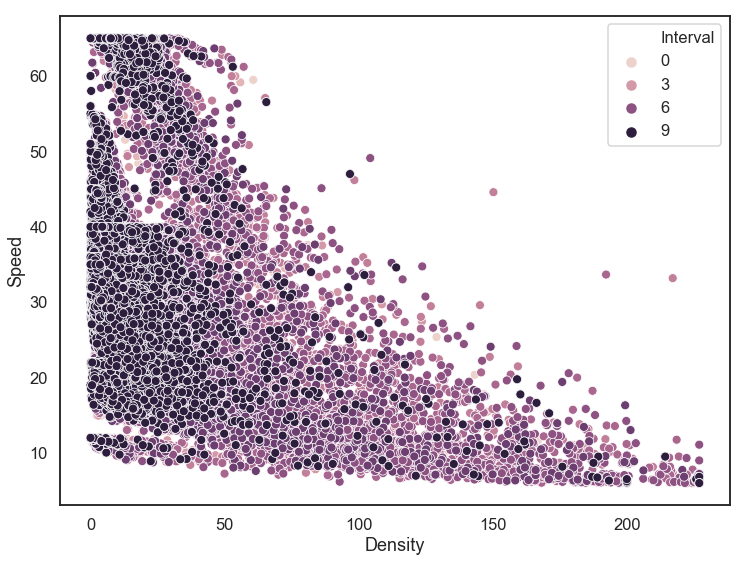

In [297]:
# Density-speed relationship is not visible with hourly data
fig, ax = plt.subplots(figsize=(12,9))
sns.scatterplot(x='Density', y='Speed',hue='Interval', data=df_metric)

In [190]:
df_metric.VC.describe()

count    234306.000000
mean          0.282158
std           0.261896
min           0.000000
25%           0.095238
50%           0.204311
75%           0.390629
max           5.656652
Name: VC, dtype: float64

In [191]:
df_metric.VC2.describe()

count    234306.000000
mean          0.132596
std           0.150232
min           0.000000
25%           0.036111
50%           0.081528
75%           0.170961
max           1.264444
Name: VC2, dtype: float64

In [283]:
df_metric.iloc[df_metric.VC2.idxmax()]

Link                           45485
Anode                          17216
Bnode                          17215
Interval                           4
Flow                            2276
Density                       105.17
Speed                          30.42
Travel_Time                     0.14
Volume                       2150.83
Street             HOV/TRANSIT FACIL
Ltype                              3
Distance                     0.06873
Length                       362.894
Lanes                              1
Speed_limit                       56
Satflow                         1800
Serflow                         1813
Total_Volume                   13629
Avg_Travel_Time             0.180479
Avg_Delay                  -0.000723
FF_Time                    0.0736393
TTR                          1.90116
VC                           1.25538
VC2                          1.26444
Flow2                        2150.83
Name: 103783, dtype: object

**Facility types in Dynus-T**
1. Freeway
2. Freeway Segment with Detector (for Ramp Metering)
3. On-Ramp
4. Off-Ramp
5. Arterial
6. HOT
7. Highway
8. HOV
9. Freeway HOT
10. Freeway HOV

In [291]:
# Does saturation flow rate vary with facility type?
df_metric.groupby('Ltype')['Satflow'].describe()

,count,mean,std,min,25%,50%,75%,max
Ltype,,,,,,,,
1.0,13536.0,2200.000000,0.000000,2200.0,2200.0,2200.0,2200.0,2200.0
3.0,17289.0,1800.416450,12.900236,1800.0,1800.0,1800.0,1800.0,2200.0
4.0,18.0,1800.000000,0.000000,1800.0,1800.0,1800.0,1800.0,1800.0
5.0,198918.0,1800.018098,2.690515,1800.0,1800.0,1800.0,1800.0,2200.0
9.0,3492.0,2152.577320,129.324982,1800.0,2200.0,2200.0,2200.0,2200.0
10.0,1053.0,2190.598291,58.473314,1800.0,2200.0,2200.0,2200.0,2200.0


In [292]:
df_metric.groupby('Ltype')['Serflow'].describe()

,count,mean,std,min,25%,50%,75%,max
Ltype,,,,,,,,
1.0,13536.0,2063.035904,154.227582,1365.0,2105.0,2105.0,2105.0,2105.0
3.0,17289.0,1251.996877,255.230600,388.0,1166.0,1166.0,1457.0,1911.0
4.0,18.0,1239.500000,576.749742,679.0,679.0,1239.5,1800.0,1800.0
5.0,198918.0,682.084110,107.313608,233.0,621.0,699.0,718.0,2105.0
9.0,3492.0,2085.793814,52.376618,1943.0,2105.0,2105.0,2105.0,2105.0
10.0,1053.0,2097.239316,47.923772,1781.0,2105.0,2105.0,2105.0,2105.0


In [294]:
df_metric.loc[:,['Link',
 'Anode',
 'Bnode',
 'Interval',
 'Flow',
 'Density',
 'Speed',
 'Travel_Time',
 'Volume',
 'Street',
 'Ltype',
 'Distance',
 'Length',
 'Lanes',
 'Speed_limit',
 'Satflow',
 'Serflow',
 'Total_Volume',
 'Avg_Travel_Time',
 'Avg_Delay',
 'FF_Time',
 'TTR',
 'VC']].to_csv('Link_Performance_60Min.csv', index=False)

In [152]:
# Analysis parameters
AM_LENGTH_SIM = 9
PM_LENGTH_SIM = 9
AM_LENGTH = 3
PM_LENGTH = 4
CONGESTION_TTR = 1.5